# Exercise Sheet 1
first, we import numpy to efficiently use array operations, and as it is the standard for most scientific applications in Python.

In [5]:
import numpy as np

## Assignment 1: General Metrics
We will use an adjacency matrix to represent a graph. With this, we want to implement
a) A count of the edges in the graph
b) The density of the Network
c) in and out degree of each node (put out as an array)
    With a parameter called mode that switches between degree, indegree and outdegree
d) if the adjacancy-matrix is symmetrical, aka if the graph is undirected or directed.

The first step is to find a somewhat agreed on format for the adjacency-matrix. For this, we will import the popular library networkx and view their np representation of graphs

[[0. 1. 0. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]]


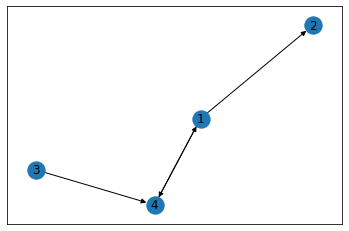

In [6]:
import networkx as nx

digraph = nx.DiGraph()
digraph.add_edge(1, 2)
digraph.add_edge(3, 4)
digraph.add_edge(4, 1)
digraph.add_edge(1, 4)

print(nx.to_numpy_matrix(digraph))

nx.draw_networkx(digraph)

Ok, this looks fairly straightforward. We can see that the first index is 
### Counting edges
Now for our first task: Counting the edges. With this non-boolean approach, we can easily do this with a complete sum.
I have decided to add another helper function to verify that a matrix can be validly interpreted as an adjacency matrix.

In [7]:
def is_adjacency_matrix(nparray):
    all_in_one_or_zero = True
    for i in np.nditer(nparray):
        if i not in [0, 1]:
            all_in_one_or_zero = False
    quadratic_shape = len(nparray.shape) == 2 and nparray.shape[0] == nparray.shape[1]

    return all_in_one_or_zero and quadratic_shape

def reject_if_not_ajmatrix(adjacency_matrix):
        if not is_adjacency_matrix(adjacency_matrix):
            raise ValueError("array can't be interpreted as an adjacency matrix.")
def count_edges(adjacency_matrix):
    reject_if_not_ajmatrix
    return np.sum(adjacency_matrix)

adjacency_matrix = nx.to_numpy_matrix(digraph)
print(count_edges(adjacency_matrix))

4.0


### Density
The density is the ration of possible edge amount in a graph to actual edge amount in a graph. We assume that we investigate a directed graph. We also add a function for counting vertices.

In [8]:
def vertice_count(adjacency_matrix):
    reject_if_not_ajmatrix(adjacency_matrix)
    return adjacency_matrix.shape[0]

def density(adjacency_matrix):
    vertice_amount = vertice_count(adjacency_matrix)
    return count_edges(adjacency_matrix) / (vertice_amount * (vertice_amount -1))

density(adjacency_matrix)

0.3333333333333333

### Degrees

full degrees: [3. 1. 1. 3.]
in degrees: [1. 1. 0. 2.]
out degrees: [2. 0. 1. 1.]


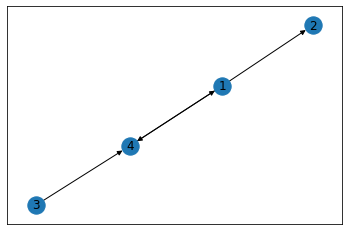

In [9]:
def degrees(matrix, mode="degree"):
    validmodes = ["indegree", "outdegree", "degree"]
    if mode not in validmodes:
        raise ValueError(f"Invalid mode. Try one of {validmodes}")
    reject_if_not_ajmatrix(matrix)
    accumulator = np.zeros((matrix.shape[0]))
    for (i, j), value in np.ndenumerate(matrix):
        if value > 0:
            if mode == "indegree":
                accumulator[j] += 1
            if mode == "outdegree":
                accumulator[i] += 1
            if mode == "degree":
                accumulator[i] += 1
                accumulator[j] += 1
    return accumulator

print(f'full degrees: {degrees(adjacency_matrix)}')
print(f'in degrees: {degrees(adjacency_matrix, mode = "indegree")}')
print(f'out degrees: {degrees(adjacency_matrix, mode = "outdegree")}')
nx.draw_networkx(digraph, pos=nx.kamada_kawai_layout(digraph))

This looks like it checks out.
### Symmetry
Now we want to determine wether the graph represented by an adjacency matrix can be viewed as undirected. This is the case if the adjacency matrix is symmetric.

In [10]:
def is_symmetrical(matrix):
    reject_if_not_ajmatrix(matrix)
    for i in range(matrix.shape[0]):
        for j in range(0, i+1):
            if not matrix[i, j] == matrix[j, i]:
                return False
    return True
# Try it out with our directed asymmetrical graph
is_symmetrical(adjacency_matrix)

False

[[0. 1. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 1.]
 [0. 0. 1. 0.]]
Is this symmetrical? Answer: True


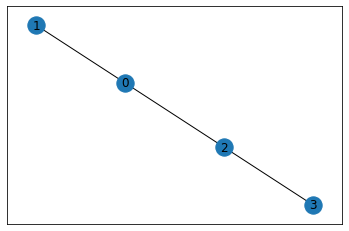

In [11]:
# Now we create a directed graph and it's matrix
graph = nx.Graph()
graph.add_edge(0, 1)
graph.add_edge(0, 2)
graph.add_edge(2, 3)

symm_matrix = nx.to_numpy_matrix(graph)
print(symm_matrix)
print(f"Is this symmetrical? Answer: {is_symmetrical(symm_matrix)}")
nx.draw_networkx(graph)



## Assignment 2: Random Graph by Degree
**Plan**:
- Select random node amount
- Calculate number of edges based on density
- Make random selection of (edge amount) fields from edgeless matrix
- Place edges there

0.7999355670103093

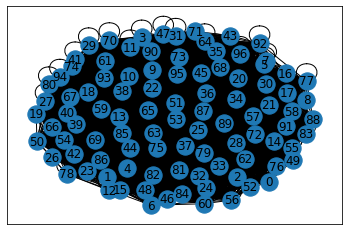

In [95]:
def random_adj_matrix(densitity, max_nodes = 1000):
    generator = np.random.default_rng()

    vertices = generator.integers(low = 1, high=max_nodes)
    edges = int(densitity * (vertices * (vertices -1)))
    matrix = np.zeros((vertices * vertices))
    indices = np.arange(0, vertices * vertices)
    selected_indices = generator.choice(indices, (edges), replace=False)
    for i in selected_indices:
        matrix[i] = 1
    return np.reshape(matrix, (vertices, vertices))

random_matrix = random_adj_matrix(0.8, 100)
random_graph = nx.from_numpy_matrix(random_matrix)
nx.draw_networkx(random_graph)

density(random_matrix)

Currently, especially if a low vertice count is selected, the density can be missed by quite a bit because of rounding. I will keep this approach though. Also, loops are allowed for now...

## Assignment 3: Diameter of a Graph
The diameter of a graph is the longest distance between any two nodes within the graph, distance meaning the length of the shortest path between two nodes.

My approach is the assembly of a distance table, which holds the distance between each two nodes as determined by dijkstras algorithm, and then determining it's maximum entry.

### Dijkstras Algorithm

distances from node 1: [ 0.  1. inf  1.]
distances from node 2: [inf  0. inf inf]
distances from node 3: [2. 3. 0. 1.]
distances from node 4: [ 1.  2. inf  0.]


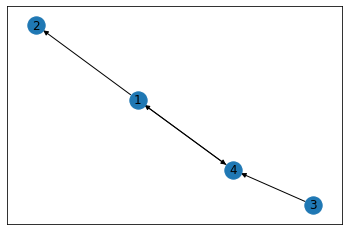

In [ ]:
def dijkstras_shortest_paths(adj_matrix, start_index):
    reject_if_not_ajmatrix(adjacency_matrix)
    distances = np.full((adj_matrix.shape[0]), np.inf)
    distances[start_index] = 0
    neighbors = [start_index]
    visited = np.full((adj_matrix.shape[0]), False)
    while len(neighbors) != 0:
        min_distance_neighbor = neighbors[0]
        for i in neighbors:
            if distances[i] < distances[min_distance_neighbor]:
                min_distance_neighbor = i
        treated_node = min_distance_neighbor
        neighbors.remove(treated_node)
        visited[treated_node] = True
        for (i, j), value in np.ndenumerate(adj_matrix[treated_node]):
            if value > 0 and not visited[j]:
                neighbors.append(j)
                distance_on_this_path = distances[treated_node] + value
                if distance_on_this_path < distances[j]:
                    distances[j] = distance_on_this_path
    return distances

print(f'distances from node 1: {dijkstras_shortest_paths(adjacency_matrix, 0)}')
print(f'distances from node 2: {dijkstras_shortest_paths(adjacency_matrix, 1)}')
print(f'distances from node 3: {dijkstras_shortest_paths(adjacency_matrix, 2)}')
print(f'distances from node 4: {dijkstras_shortest_paths(adjacency_matrix, 3)}')
nx.draw_networkx(digraph)



Much like the output before, we can now create the distance table through one application per node of dijkstras algorithm.

In [ ]:
def distance_matrix(adj_matrix):
    reject_if_not_ajmatrix(adj_matrix)
    distance_matrix = np.full_like(adj_matrix, np.inf)
    for i in range(adj_matrix.shape[0]):
        distance_matrix[i, :] = dijkstras_shortest_paths(adj_matrix, i)
    return distance_matrix

def diameter(adj_matrix):
    return np.max(distance_matrix(adj_matrix))

print(f' diametre of the digraph: {diameter(adjacency_matrix)}')

 diametre of the digraph: inf


Here we get to realize that we have a node that has no outgoing connection to any of the others, making the diameter infinite. Let's Try to create a more interesting example:

Our new Graph 
[[0. 1. 0. 0. 1.]
 [0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]] has:
full degrees: [3. 5. 3. 3. 4.]
in degrees: [1. 2. 2. 1. 3.]
out degrees: [2. 3. 1. 2. 1.]
distance matrix 
[[0. 1. 2. 2. 1.]
 [2. 0. 1. 1. 1.]
 [4. 2. 0. 3. 1.]
 [1. 2. 1. 0. 2.]
 [3. 1. 2. 2. 0.]]
and diameter 4.0


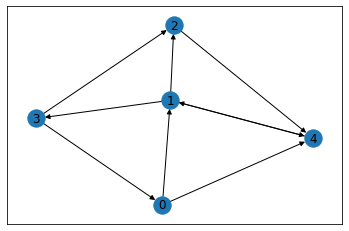

In [ ]:
new_graph = nx.DiGraph()
new_graph.add_nodes_from([0, 1, 2, 3, 4])
new_graph.add_edge(0, 4)
new_graph.add_edge(1, 3)
new_graph.add_edge(1, 4)
new_graph.add_edge(3, 0)
new_graph.add_edge(0, 1)
new_graph.add_edge(1, 4)
new_graph.add_edges_from([(1, 2), (2, 4), (3, 2), (4, 1)])
new_adj_matrix = nx.to_numpy_matrix(new_graph)

print(f'Our new Graph \n{new_adj_matrix} has:')
print(f'full degrees: {degrees(new_adj_matrix)}')
print(f'in degrees: {degrees(new_adj_matrix, mode = "indegree")}')
print(f'out degrees: {degrees(new_adj_matrix, mode = "outdegree")}')
print(f'distance matrix \n{distance_matrix(new_adj_matrix)}')
print(f'and diameter {diameter(new_adj_matrix)}')
nx.draw_networkx(new_graph)
